In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, MFDataset
import pandas as pd
from scipy import spatial
from datetime import datetime
from datetime import timedelta
#import os.path
#import cmath 
#import xarray as xr

- The data was copied from /work/ollie/gallen/data_4_TR/

- 6 experiments:
LGM  ORB002  ORB006  ORB02lgm  ORB06lgm  PI

- For each experiment, there is:
- U10 and V10 in xxx_u10_v10_ymonmean_r360x180.nc
- T (VAR: THO), S (VAR: SAO), Sea ice (Var: SICOMO) and SSH (Var: ZO) in xxx_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc
- OCN-U and OCN-V in xxx_UKOandVKE_ymonmean_UVrotated_r360x180.nc

- 2 more experiments from /work/ba0989/a270078/Data_for_ThomasR/LGM27ka and /work/ba0989/a270078/Data_for_ThomasR/LGM28p7 (28.7ka orbital configuration, in which the summer insolation over Southern Ocean is close its minimum in the last 40ka)

In [2]:
ls

LGM/
LGM27ka/
LGM28p7/
LGM_awicm/
LGM_toXun.png
ORB002/
ORB006/
ORB02lgm/
ORB05lgm/
ORB06lgm/
PI/
PI_awicm/
PI_toXun.png
README.md
Wesche-Dierking_2015.csv
pyberg_standalone.ipynb
pyberg_standalone_classes.ipynb
pyberg_standalone_classes_LGM.ipynb
pyberg_standalone_classes_NEW_LGM.ipynb
pyberg_standalone_classes_NEW_LGM_ORB002.ipynb
pyberg_standalone_classes_NEW_LGM_ORB006.ipynb
pyberg_standalone_classes_NEW_LGM_ORB02lgm.ipynb
pyberg_standalone_classes_NEW_LGM_ORB05lgm.ipynb
pyberg_standalone_classes_NEW_LGM_ORB06lgm.ipynb
pyberg_standalone_classes_NEW_PI.ipynb
pyberg_standalone_classes_WescheDierking_PI-LGM27ka.ipynb
pyberg_standalone_classes_WescheDierking_PI-LGM28p7ka.ipynb
pyberg_standalone_classes_WescheDierking_PI.ipynb
pyberg_standalone_classes_WescheDierking_PI_larger.ipynb
pyberg_standalone_classes_WescheDierking_PI_melt.ipynb
pyberg_standalone_classes_works.ipynb
pyberg_standalone_toXun.ipynb
pyberg_standalone_toXun_works.ipynb


In [166]:
cd ./PI/

/Users/trackow/Documents/science-icebergs-lgm/PI


In [167]:
ls

PI_6912lats_forAidan.csv
PI_6912lons_forAidan.csv
PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc
PI_lats_to_Xun.csv
PI_lons_to_Xun.csv
PI_lons_to_Xun.mat
PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc
PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc


In [168]:
EXP='PI'

### look at the data

In [169]:
# a useful function we'll need

r_earth=6.3675*10**6 # radius of Earth in [m]
rad=np.pi/180.0 # radiant <-> degree

def length_of_latitude_circle(lat=85.):
    return 2*np.pi*r_earth*np.cos(lat*rad) / 1000. # km

In [170]:
# load interpolated COSMO data (1x1 degree)
def loaddate_ofCOSMO(filen, variable, returncoords=False, threeD=False):
    
    # let's construct the file name
    pathtofile="./"
    # UO, VO, sisnconc, sithick, so, thetao, zos
    endfilename= '_ymonmean_r360x180.nc'
    
    # the file to be loaded
    filename=pathtofile + filen + endfilename
    
    print("loading "+filename+ " ...") # Python3 needs brackets here
    
    # load the file
    fl = Dataset(filename)

    # lon lat on grid
    lon_start=np.copy(fl.variables['lon'])
    lat_start=np.copy(fl.variables['lat'])
    inputfield=np.copy(fl.variables[variable])
    if threeD==True:
        depth=np.copy(fl.variables['lev'])
    
    fl.close()
        
    if returncoords==True and threeD==False:
        XX,YY=np.meshgrid(lon_start,lat_start)
        return inputfield, XX, YY
    elif returncoords==True and threeD==True:
        XX,YY=np.meshgrid(lon_start,lat_start)
        return inputfield, XX, YY, depth
    else:
        return inputfield

In [171]:
# load interpolated FESOM data (1x1 degree)
def loaddate_ofFESOM(filen, variable, returncoords=False, threeD=False):
    
    # let's construct the file name
    pathtofile="./"
    # UO, VO, sisnconc, sithick, so, thetao, zos
    endfilename= '_yr3200to3299_ymonmean_r360x180.nc'
    
    # the file to be loaded
    filename=pathtofile + filen + endfilename
    
    print("loading "+filename+ " ...") # Python3 needs brackets here
    
    # load the file
    fl = Dataset(filename)

    # lon lat on grid
    lon_start=np.copy(fl.variables['lon'])
    lat_start=np.copy(fl.variables['lat'])
    inputfield=np.copy(fl.variables[variable])
    if threeD==True:
        depth=np.copy(fl.variables['depth'])
    
    fl.close()
        
    if returncoords==True and threeD==False:
        XX,YY=np.meshgrid(lon_start,lat_start)
        return inputfield, XX, YY
    elif returncoords==True and threeD==True:
        XX,YY=np.meshgrid(lon_start,lat_start)
        return inputfield, XX, YY, depth
    else:
        return inputfield

In [172]:
def plot_field(plotfield, cbar_label='field', vmin=-2., vmax=2.):
    
    m = Basemap(projection='spstere',boundinglat=-40,lon_0=180,resolution='l')
    #m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')
    m.drawcoastlines()

    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))

    # plot
    lon_map,lat_map=m(XX[:,:],YY[:,:])
    im=m.contourf(lon_map,lat_map,plotfield,vmin=vmin, vmax=vmax)

    # colorbar
    cbar=plt.colorbar()
    cbar.set_label(cbar_label)

    plt.show()

loading ./PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc ...


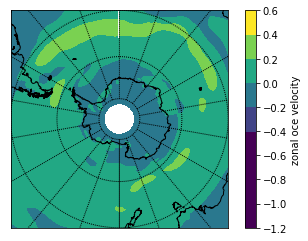

In [173]:
# load the variables and plot them
filen=EXP+'_mpiom_last100year_wiso_catted.selvars_UKOandVKE' #'fesom_regular_UO'
variable='UKO'
cbar_label='zonal oce velocity'
vmin, vmax=-.5,0.5

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
level=39 # 0:bottom, 39:top
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,level,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc ...


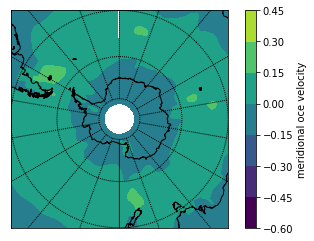

In [174]:
# load the variables and plot them
filen=EXP+'_mpiom_last100year_wiso_catted.selvars_UKOandVKE' #'fesom_regular_VO'
variable='VKE'
cbar_label='meridional oce velocity'
vmin, vmax=-.5,0.5

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
level=39 # 0:bottom, 39:top
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,level,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...


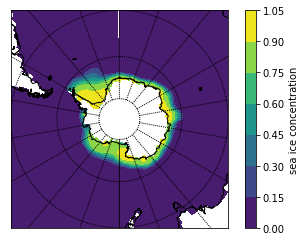

In [175]:
# load the variables and plot them
filen=EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO' #'fesom_regular_sisnconc'
variable='SICOMO'
cbar_label='sea ice concentration'
vmin, vmax=0.,1. #00.

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
#level=0
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...


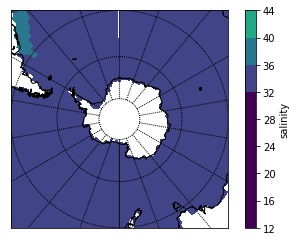

In [176]:
# load the variables and plot them
filen=EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO' #'fesom_regular_so'
variable='SAO'
cbar_label='salinity'
vmin, vmax=30.,50.

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
level=39
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,level,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...


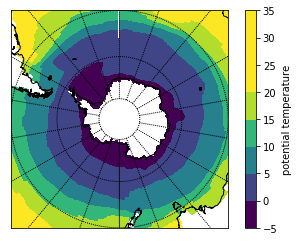

In [177]:
# load the variables and plot them
filen=EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO' #'fesom_regular_thetao'
variable='THO'
cbar_label='potential temperature'
vmin, vmax=-2.,20.

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
level=39
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,level,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...


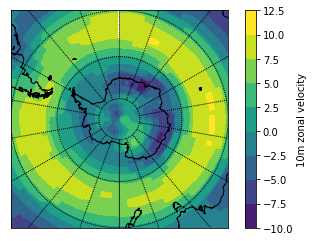

In [178]:
# load the variables and plot them
filen=EXP+'_echam5_last100year_catted_u10_v10' #'MM'
variable='u10'
cbar_label='10m zonal velocity'
vmin, vmax=-10.5,10.5

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
#level=0
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...


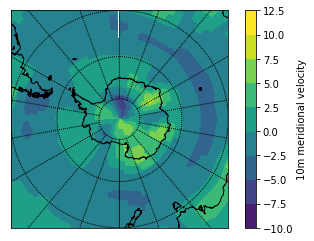

In [179]:
# load the variables and plot them
filen=EXP+'_echam5_last100year_catted_u10_v10'
variable='v10'
cbar_label='10m meridional velocity'
vmin, vmax=-10.5,10.5

# load the data
plotfield, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan; which month and level?
month=0
#level=0
plotfield[plotfield==-9.e+33]=np.nan
plotfield=plotfield[month,:,:]

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...


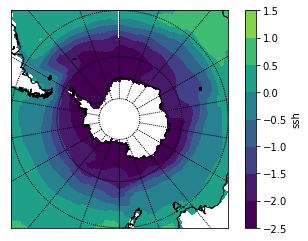

In [180]:
# load the variables and plot them
filen=EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO'
variable='ZO'
cbar_label='ssh'
vmin, vmax=-2.,2.

# load the data
SSH, XX, YY = loaddate_ofCOSMO(filen, variable, returncoords=True)

# set to nan and which month?
month=0
#level=0
SSH[SSH==-9.e+33]=np.nan

# plot the field
plot_field(SSH[month,:,:], cbar_label=cbar_label, vmin=vmin, vmax=vmax)

In [181]:
def compute_gradient(SSH, XX, YY):
    
    # add column to the left and right
    addcol=np.concatenate([np.expand_dims(SSH[:,:,-1],axis=2),SSH,np.expand_dims(SSH[:,:,0], axis=2)],axis=2)
    addcXX=np.concatenate([np.expand_dims(np.ones_like(XX[:,-1])*-1.,axis=1),XX,np.expand_dims(np.ones_like(XX[:,0])*360., axis=1)],axis=1)
    addcYY=np.concatenate([np.expand_dims(YY[:,-1],axis=1),YY,np.expand_dims(YY[:,0], axis=1)],axis=1)
    
    # SSH: (12, 180, 362) # already has columns added left and right
    lats=YY[:,0]
    ddx=np.zeros_like(SSH)
    ddy=np.zeros_like(SSH)
    
    # 1 ... 360 (0 and 361 were added)
    for column in np.arange(1,360+1):
        #print column
        ddx[:,:,column-1]=(addcol[:,:,column+1]-addcol[:,:,column-1])/(2.*111000.)
        
    for row in np.arange(1,180-1):
        #print row
        ddy[:,row,:]=(SSH[:,row+1,:]-SSH[:,row-1,:])/(2.*111000.*np.cos(YY[row,0]*rad))
        
    return ddx, ddy

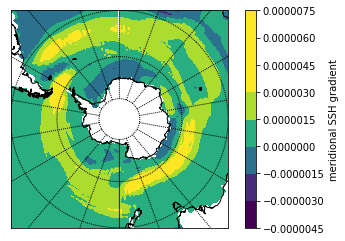

In [182]:
ddx, ddy = compute_gradient(SSH, XX, YY)

# which month and component?
cbar_label="meridional SSH gradient"
vmin=-3e-6
vmax=3e-6
month=0
plotfield=np.squeeze(ddy[month,:,:])

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

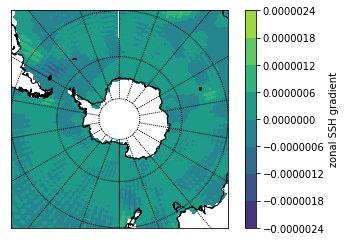

In [183]:
# get sea surface height slope

# which month and component?
cbar_label="zonal SSH gradient"
vmin=-3e-6
vmax=3e-6
month=0
plotfield=np.squeeze(ddx[month,:,:])

# plot the field
plot_field(plotfield, cbar_label=cbar_label, vmin=vmin, vmax=vmax)

#### The iceberg drift (and decay) code

In [184]:
class Buoys:
    
    global rad, r_earth, g, omega, Co, Ca, Cdo_skin, Cda_skin, semiimplicit_coeff, rho_h2o, rho_icb, rho_air, smallestvol_icb, coriolis_slope_only, l_weeksmellor
    
    rad=np.pi/180.0 # radiant <-> degree
    r_earth=6.3675*10**6 # radius of Earth in [m]
    g=9.81
    omega=7.2921e-5 # make latitude dependent later
    
    # if using iceberg dynamics:
    Co=0.85 # Lichey and Hellmer values
    Ca=1.4 # 0.4 # Lichey and Hellmer values
    Cdo_skin=5.0e-3 # Cd_oce_ice in FESOM is 5.0e-3
    Cda_skin=2.5e-3
    rho_icb=850.0 # Silva et al. 2006
    rho_h2o=1027.5
    rho_air=1.293
    smallestvol_icb=1000. #10000. # [m**3]
    semiimplicit_coeff=1.0 # fully implicit # 0.5 default
    coriolis_slope_only=False
    l_weeksmellor=True
    
    def __init__(self, lon_start, lat_start, earliest_date_of_buoy, start_advect_date, L, W, H):
        self.oldlon = lon_start*rad
        self.oldlat = lat_start*rad
        self.lon = lon_start*rad
        self.lat = lat_start*rad
        self.initlon = lon_start*rad
        self.initlat = lat_start*rad
        self.old_u = np.zeros(lon_start.shape)
        self.old_v = np.zeros(lon_start.shape)
        self.date = datetime.strptime(earliest_date_of_buoy, "%Y-%m-%d %H:%M:%S")
        self.startdates = start_advect_date
        self.L=L
        self.W=W
        self.H=H
        self.mass=L*W*H*rho_icb
        self.D = (rho_icb/rho_h2o)*H
        self.Ao = self.D * L
        self.Aa = (H - self.D) * L
        self.Ad = L * W
        self.massloss= 0. # m^3/second
       
    def getdate(self):
        return self.date.strftime("%Y-%m-%d %H:%M:%S")
    
    def getmonth_forcing(self):
        return np.int(self.date.month)-1
        
    def trajectory(self, new_u,new_v, delta_t):
        
        #print("Update buoy positions. Integrate for " + str(delta_t/3600.) + " hours.")
        
        #save old position in case the drifter leaves the domain
        self.oldlon = self.lon # radiant
        self.oldlat = self.lat # radiant
        
        #displacement vectors
        deltax1 = self.old_u * delta_t
        deltay1 = self.old_v * delta_t
        deltax2 = new_u * delta_t
        deltay2 = new_v * delta_t
        
        #Heun method (2nd order)
        self.lon = self.lon + (0.5*(deltax1 + deltax2) / (r_earth*np.cos(self.lat.values)) )
        self.lat = self.lat + (0.5*(deltay1 + deltay2) /  r_earth )
        
        # keep degree in range 0..360 and -90..90
        lon_deg=self.lon/rad % 360
        lat_deg=np.clip(self.lat/rad, -90., 90.)
        self.lon = lon_deg*rad
        self.lat = lat_deg*rad
        
        #update velocity here (old value was needed for heun method)
        self.old_u=new_u
        self.old_v=new_v
        
        # set positions to NaN before the buoy is supposed to move
        idx=getindices_beforestart(self.getdate(), self.startdates)
        lon_deg[idx] = np.nan
        lat_deg[idx] = np.nan
        self.lon[idx] = self.initlon[idx]
        self.lat[idx] = self.initlat[idx]
        self.old_u[idx]=0.
        self.old_v[idx]=0.
        
        # update time stamp
        self.date = self.date + timedelta(seconds=delta_t)

        return lon_deg, lat_deg
    
    def momentum_balance(self, au_ib, av_ib, dt_ib, uo_ib, vo_ib, uo_skin_ib, vo_skin_ib):
        
        new_u_ib = self.old_u + au_ib * dt_ib
        new_v_ib = self.old_v + av_ib * dt_ib
        
        # for semiimplicit version, a matrix multiplication is to be performed
        # (semiimpl. coriolis term and implicit water drag)
 
        abs_omib = np.sqrt( (uo_ib - self.old_u)**2 + (vo_ib - self.old_v)**2 )
        abs_omib_skin = np.sqrt( (uo_skin_ib - self.old_u)**2 + (vo_skin_ib - self.old_v)**2 )
        ocean_drag = (0.5 * Co * rho_h2o * self.Ao * abs_omib + rho_h2o * Cdo_skin * self.Ad * abs_omib_skin)/self.mass
   
        # update fcoriolis
        fcoriolis=2.*omega*np.sin(self.lat.values)
        
        # for tests with Coriolis and surface slope only
        if coriolis_slope_only==True:
            ocean_drag=np.zeros_like(abs_omib_skin)
        
        #SI_matrix(1,1) = 1. + dt_ib*ocean_drag
        #SI_matrix(1,2) = dt_ib*fcoriolis*semiimplicit_coeff
        #SI_matrix(2,1) =-SI_matrix(1,2)
        #SI_matrix(2,2) = SI_matrix(1,1)
        #SI_matrix = (1./( SI_matrix(2,2)**2 + SI_matrix(1,2)**2 )) * SI_matrix
        SI_matrix=np.array([[1. + dt_ib*ocean_drag, dt_ib*fcoriolis*semiimplicit_coeff*np.ones_like(ocean_drag)], \
                            [-dt_ib*fcoriolis*semiimplicit_coeff*np.ones_like(ocean_drag), 1. + dt_ib*ocean_drag]])
        SI_matrix = (1./( SI_matrix[1,1]**2 + SI_matrix[0,1]**2 )) * SI_matrix
        
        # new velocity after matrix multiplication
        # (2, 2, #bergs) x (2, #bergs)
        uv_temp=np.array([new_u_ib, new_v_ib])
        new_u_ib=sum(SI_matrix[0, 0:2, :] * uv_temp[0:2 , :])
        new_v_ib=sum(SI_matrix[1, 0:2, :] * uv_temp[0:2 , :])
        
        # rewrite like this..?
        #SI_matrix = np.einsum('ijn->nij', SI_matrix)
        #new_UV = np.dot(SI_matrix,[new_u_ib, new_v_ib])
        
        # might be melted already
        new_u_ib[self.mass==0.]=0.
        new_v_ib[self.mass==0.]=0.
        
        return new_u_ib, new_v_ib
    
    def compute_areas(self):
        
        # area of iceberg exposed to ocean, atm, (seaice), horizontal area
        self.Ao = self.D * self.L
        self.Aa = (self.H - self.D) * self.L
        # Ai = hi_ib * self.L
        self.Ad = self.L * self.W
    
    def acceleration(self, ua_ib, va_ib, uo_ib, vo_ib, uo_skin_ib, vo_skin_ib, detadx, detady):
        
        l_wave=True
        #l_wave=False
    
        # estimate wave height at the icebergs location (Bigg et al., 1997),
        # so wave_amplitude = 0.5 * wave_height = 0.5 * const. * abs(atm velo)**2
        vel_atm = np.sqrt(ua_ib**2 + va_ib**2)
        wave_amplitude = 0.5 * 0.02025 * vel_atm**2

        # assume that waves have same direction as the winds
        direction_u = ua_ib / vel_atm
        direction_v = va_ib / vel_atm

        # absolute values of relative velocities 
        abs_omib = np.sqrt( (uo_ib - self.old_u)**2 + (vo_ib - self.old_v)**2 )
        abs_amib = np.sqrt( (ua_ib - self.old_u)**2 + (va_ib - self.old_u)**2 )
        #abs_imib = sqrt( (ui_ib - u_ib)**2 + (vi_ib - v_ib)**2 )  
        abs_omib_skin = np.sqrt( (uo_skin_ib - self.old_u)**2 + (vo_skin_ib - self.old_v)**2 )

        # u-components        
        ocean_drag_u     = (0.5 * Co * rho_h2o * self.Ao * abs_omib * uo_ib)/self.mass #calculate part of it implicitly
        ocean_skin_u     = (rho_h2o * Cdo_skin * self.Ad * abs_omib_skin * uo_skin_ib)/self.mass # calculate part of it implicitly      
        air_drag_u       = (0.5 * Ca * rho_air * self.Aa * abs_amib * (ua_ib - self.old_u))/self.mass
        air_skin_u       = (rho_air * Cda_skin * self.Ad * abs_amib * (ua_ib - self.old_u))/self.mass 
        #ice_drag_u       = (0.5 * Ci * rho_ice * Ai * abs_imib * (ui_ib - u_ib))/mass_ib

        if l_wave==True:
            wave_radiation_u = 1./4. * rho_h2o * g * self.L * wave_amplitude**2 * direction_u /self.mass
        else:
            wave_radiation_u = 0.0

        # Fortran code used gradient smoothing for surface slope term
        # call mean_gradient(iceberg_elem, lon_rad, lat_rad, nablaeta)
        # no surface slope due to tides here

        surface_slope_u = -g * detadx #* sum( ssh(elem2D_nodes(:,iceberg_elem)) * bafux_2D(:,iceberg_elem) ) # -g* nabla ssh


        # v-components     
        ocean_drag_v     = (0.5 * Co * rho_h2o * self.Ao * abs_omib * vo_ib)/self.mass # calculate part of it implicitly
        ocean_skin_v     = (rho_h2o * Cdo_skin * self.Ad * abs_omib_skin * vo_skin_ib)/self.mass #calculate part of it implicitly
        air_drag_v       = (0.5 * Ca * rho_air * self.Aa * abs_amib * (va_ib - self.old_v))/self.mass
        air_skin_v       = (rho_air * Cda_skin * self.Ad * abs_amib * (va_ib - self.old_v))/self.mass 
        #ice_drag_v       = (0.5 * Ci * rho_ice * Ai * abs_imib * (vi_ib - v_ib))/mass_ib

        if l_wave==True:
            wave_radiation_v = 1./4. * rho_h2o * g * self.L * wave_amplitude**2 * direction_v /self.mass
        else:
            wave_radiation_v = 0.0

        # no additional surface slope due to tides

        surface_slope_v = -g * detady #* sum( ssh(elem2D_nodes(:,iceberg_elem)) * bafuy_2D(:,iceberg_elem) )

        #USE (SEMI-)IMPLICIT SCHEME for coriolis term
        
        # update fcoriolis
        fcoriolis=2.*omega*np.sin(self.lat.values)

        au_ib = ocean_drag_u \
        + ocean_skin_u    \
        + air_drag_u       \
        + air_skin_u        \
        + wave_radiation_u   \
        + surface_slope_u    \
        + (1.-semiimplicit_coeff)*fcoriolis*self.old_v 

        av_ib = ocean_drag_v \
        + ocean_skin_v    \
        + air_drag_v       \
        + air_skin_v        \
        + wave_radiation_v   \
        + surface_slope_v    \
        - (1.-semiimplicit_coeff)*fcoriolis*self.old_u
        
        
        # TEST FOR CORIOLIS and SLOPE:
        if coriolis_slope_only==True:
            au_ib = surface_slope_u + (1.-semiimplicit_coeff)*fcoriolis*self.old_v 
            av_ib = surface_slope_v - (1.-semiimplicit_coeff)*fcoriolis*self.old_u
            
            
        # might be melted already    
        au_ib[self.mass==0.] = 0.   
        av_ib[self.mass==0.] = 0.
        
        return au_ib, av_ib
    
    def iceberg_meltrates(self, delta_t, sst_ib, conci_ib, uo_ib, vo_ib, ua_ib, va_ib, heuristic=False):
        
        if heuristic==True:
            
            # rate in m/s
            rate_per_month=1.7/100. # area (L*L) red. rate in m/month (Barbat et al., 2020)
            rate_per_second=np.sqrt(rate_per_month/(86400.*30.)) # L red. rate
            
            self.L = self.L - delta_t*rate_per_second
            self.W = self.W - delta_t*rate_per_second
            self.mass = self.H * self.L * self.W * rho_icb
            
        else:
            
            # calculates the empirical melt rates of the iceberg as in 
            # Martin: 'Parameterizing the fresh-water flux from land ice to ocean
            # with interactive icebergs in a coupled climate model'(2010)
            # and Hellmer et al. (1997).
            # (notice that the melt rates are in terms of m/s though, not in m/day)
            
            # bottom melt rate: M_b   [m/s]
            # lateral melt rate: M_v   [m/s]
            # wave erosion: M_e   [m/s]
            # lateral (basal) melt rate: M_bv [m/s]

            # NO (3eq formulation for basal melting yet;
            # use 3D information for T,S and velocities
            # instead of SSTs; M_v depends on 'thermal driving')
  
            # bottom melt (basal turbulent melting rate)
            M_b = np.zeros_like(self.L)
            M_b[self.L>0.] = 0.58 * np.sqrt( (self.old_u[self.L>0.] - uo_ib[self.L>0.])**2 + (self.old_u[self.L>0.] - vo_ib[self.L>0.])**2 )**0.8 * (sst_ib[self.L>0.] + 4.0) / self.L[self.L>0.]**0.2
            M_b = M_b/86400. # conversion of m/day to m/s

            #3-eq. formulation for bottom melting [m/s]    
            #v_ibmino  = sqrt( (u_ib - uo_keel_ib)**2 + (v_ib - vo_keel_ib)**2 )
            #call iceberg_heat_water_fluxes_3eq(ib, M_b, T_keel_ib,S_keel_ib,v_ibmino, depth_ib, tf)

            #3-eq. formulation for lateral 'basal' melting [m/s]
            #v_ibmino  = sqrt( (u_ib - uo_ib)**2 + (v_ib - vo_ib)**2 ) ! depth-average rel. velocity
            #call iceberg_heat_water_fluxes_3eq(ib, M_bv, T_ave_ib,S_ave_ib,v_ibmino, depth_ib/2.0, tf)
            M_bv=M_b

            #'thermal driving', defined as the elevation of ambient water 
            #temperature above freezing point' (Neshyba and Josberger, 1979).
            
            T_ave_ib=sst_ib # use sst for the moment
            tf=-2. # use constant value at the moment
            
            # thermal driving temp
            T_d = (T_ave_ib - tf) * np.ones_like(self.L)
            T_d[T_d < 0.]=0. 
            
            #!write(*,*) 'thermal driving:',T_d,'; Tf:',tf,'T_ave:',T_ave_ib

            #lateral melt (buoyant convection)
            #M_v = 0.00762 * sst_ib + 0.00129 * sst_ib**2
            #M_v = M_v/86400.
            #M_v is a function of the 'thermal driving', NOT just sst! Cf. Neshyba and Josberger (1979)
            M_v = 0.00762 * T_d + 0.00129 * T_d**2
            M_v = M_v/86400.

            #wave erosion
            absamino = np.sqrt( (ua_ib - uo_ib)**2 + (va_ib - vo_ib)**2 )
            sea_state = 3./2.*np.sqrt(absamino) + 1./10.*absamino
            damping = 0.5 * (1.0 + np.cos(conci_ib**3 * np.pi))
            M_e = 1./6. * sea_state * T_d * damping # replaced (sst_ib + 2.0) by Td
            M_e = M_e/86400.
            
            M_b[np.isnan(M_b)]=0.
            M_v[np.isnan(M_v)]=0.
            M_e[np.isnan(M_e)]=0.
            M_bv[np.isnan(M_bv)]=0.
            
        return M_b, M_v, M_e, M_bv
    
    def weeksmellor(self, volume_after):
    
        # check stability
        # l_rollover = (length_ib < sqrt(0.92 * height_ib**2  +  58.32 * height_ib)) # old FORTRAN
        epsilon = self.W/self.H
        alpha = rho_icb/rho_h2o
        epsilon_crit = np.sqrt(6*alpha*(1-alpha))
        l_rollover = epsilon < epsilon_crit
    
        # if l_rollover == True:
        self.H[l_rollover]= self.L[l_rollover] # new height is the previous length
        self.D = self.H * alpha
            
        # calculate L and W so that volume is still correct
        self.L[l_rollover] = np.sqrt(volume_after[l_rollover]/self.H[l_rollover])
        self.W = self.L
            

    def iceberg_newdimensions(self, delta_t, M_b,M_v,M_e,M_bv):
        
        # changes in this timestep:
        dh_b = M_b*delta_t # change of height..
        dh_v = M_v*delta_t # ..and length due to melting..
        dh_e = M_e*delta_t # ..and due to wave erosion [m].
        dh_bv = M_bv*delta_t # M_bv*dt # change of length due to 'basal meltrate'
        
        # CALCULATION OF WORKING SURFACES AS IN BIGG (1997) & SILVA (2010)
        # basal volume loss
        bvl = dh_b*self.L**2
        
        # lateral volume loss
        lvl_e = dh_e*self.L*self.H + dh_e*self.W*self.H # erosion just at 2 sides
        lvl_b = dh_bv*2.*self.L*self.D + dh_bv*2*self.W*self.D # at all 4 sides
        lvl_v = dh_v*2.*self.L*self.D + dh_v*2*self.W*self.D # at all 4 sides
        # total volume loss
        tvl = bvl + lvl_b + lvl_v + lvl_e # [m^3] per timestep
        volume_before=self.H*self.L*self.W
    
        #if((tvl*rho_icb >= self.mass) or (self.mass <= 1000.*rho_icb)):
        
        # if more ice is to be melted than there is, or when the mass is smaller than allowed
        whereidx=np.logical_or(tvl*rho_icb >= self.mass, self.mass <= smallestvol_icb*rho_icb)
        tvl[whereidx] = self.mass[whereidx] / rho_icb
        self.mass[whereidx] = 0.
        self.L[whereidx] = 0.
        self.W[whereidx] = 0.
        self.H[whereidx] = 0.
        self.D[whereidx] = 0.        
            
        # define last tvl to be erosional loss
        bvl[whereidx] = 0.0
        lvl_b[whereidx] = 0.0
        lvl_v[whereidx] = 0.0
        lvl_e[whereidx] = tvl[whereidx]

        #volume_after=volume_before-tvl
            
        # calculating the new iceberg dimensions
        # print('max dh_b', np.max(dh_b))
        self.H = self.H - dh_b
        self.H[self.H< 0.]=0. # in case basal melt is strong
        self.D = self.H * rho_icb/rho_h2o
    
        # calculate L so that new volume is correct
        volume_after=self.H*self.L*self.W
        self.L[self.H >0.] = np.sqrt(volume_after[self.H >0.]/self.H[self.H >0.])
        self.W = self.L # quadratic at the moment
    
        #distribute dh_e equally between length and width
        #as in code of michael schodlok, but not dh_v? 
        #length_ib= length_ib - dh_v -dh_e/2.
        #width_ib = width_ib  - dh_v -dh_e/2.
    
        #volume_after=height_ib*length_ib*width_ib

        # iceberg smaller than critical value after melting?
        #if (volume_after <= smallestvol_icb):
        whereidx=(volume_after <= smallestvol_icb)
            
        volume_after[whereidx]=0.0
        self.D[whereidx] = 0.0
        self.H[whereidx]= 0.0
        self.L[whereidx]= 0.0
        self.W[whereidx] = 0.0
        tvl[whereidx] = volume_before[whereidx]
        # define last tvl to be erosional loss
        #bvl = 0.0
        #lvl_b = 0.0
        #lvl_v = 0.0
        #lvl_e = tvl
        
        self.mass = self.mass - tvl*rho_icb
        self.massloss = tvl*rho_icb / delta_t
    
        # stability criterion: icebergs are allowed to roll over
        #  call weeksmellor(	depth_ib, height_ib, length_ib, width_ib, rho_h2o, rho_icb, volume_after)  
        epsilon= self.W/self.H
        alpha = rho_icb/rho_h2o
        epsilon_crit = np.sqrt(6*alpha*(1-alpha)) # Wagner et al. (2017), http://dx.doi.org/10.1016/j.ocemod.2017.07.003
        if l_weeksmellor: 
            self.weeksmellor(volume_after)

        #OUTPUT of averaged meltrates in [m^3 (ice) per day]
        #bvl_mean(ib)=bvl_mean(ib)+(bvl/real(icb_outfreq))
        #lvlv_mean(ib)=lvlv_mean(ib)+(lvl_v/real(icb_outfreq))
        #lvle_mean(ib)=lvle_mean(ib)+(lvl_e/real(icb_outfreq))
        #lvlb_mean(ib)=lvlb_mean(ib)+(lvl_b/real(icb_outfreq))

In [185]:
# find the buoys that are not to be advected yet (current date < start date)
def getindices_beforestart(currentdate, startdates):
        
    indices=np.zeros(np.shape(start_dates),dtype='bool')
    for i,val in enumerate(startdates):
        # don't advect yet
        if currentdate < startdates[i]:
            indices[i]=True
            
    return indices

In [186]:
# nearest-neighbor interpolation, finds U,V at the position of the buoys using a fast KDTree method
def find_UV_atbuoy_pos(XX,YY, Ufield,Vfield, objects, returnidx=False):
    
    # (lon,lat) tuples of the underlying grid
    A=np.array([XX[:,:].flatten(), YY[:,:].flatten()]).T # -180..180 assumed in OSISAF
    
    # don't change to -180..180 as assumed in OSISAF data; in the trajectory code its 0..360
    #lon_adjust=objects.lon/rad
    #lon_adjust[lon_adjust>180.]=lon_adjust[lon_adjust>180.]-360.
    
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((objects.lon/rad,objects.lat/rad)) 
    # fast KDTree nearest neighbor method
    idx=spatial.KDTree(A).query(tuples)[1]
    
    #if np.any(idx==np.shape(XX[:,:].flatten())[0]):
    #    print(A.min(), A.max(), tuples.min(), tuples.max(), idx)
    #    return np.zeros_like(idx), np.zeros_like(idx)
    #else:
    if returnidx==True:
        return Ufield[idx], Vfield[idx], idx
    else:
        return Ufield[idx], Vfield[idx]

In [187]:
def find_idx_atbuoy_pos(XX,YY, poslon, poslat):
    
    # (lon,lat) tuples of the underlying grid
    A=np.array([XX[:,:].flatten(), YY[:,:].flatten()]).T # -180..180 assumed in OSISAF
    # don't change to -180..180 as assumed in OSISAF data; poslon is 0..360 and
    # the remapped data as well
    #lon_adjust=poslon
    #lon_adjust[lon_adjust>180.]=lon_adjust[lon_adjust>180.]-360.
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((poslon,poslat)) 
    
    # fast KDTree nearest neighbor method
    return spatial.KDTree(A).query(tuples)[1]

### Let's compute the trajectories

In [188]:
ls ../Wesche-Dierking_2015.csv

../Wesche-Dierking_2015.csv


In [189]:
# Latitude / Longitude / Area [km**2] / Perimeter [m] / width [m] / length [m] / Orientation [deg]

In [190]:
DATA = np.loadtxt('../Wesche-Dierking_2015.csv',delimiter=';',skiprows=19,comments="*/")
DATA.shape, DATA[:,1].min(), DATA[:,1].max()

((6912, 7), -165.9942, 169.4438)

In [191]:
# use Weddell Sea icebergs only
weddell_idx=np.logical_and(DATA[:,1]>=-63., DATA[:,1]<=-45.)
poslat,poslon,areas=DATA[weddell_idx,0],DATA[weddell_idx,1],DATA[weddell_idx,2]
# all
#poslat,poslon,areas=DATA[:,0],DATA[:,1],DATA[:,2] 

lengths=np.sqrt(areas)*1000. # to meters
widths=lengths
heights=np.ones_like(poslon)*250. #0. # 250m
num_buoys=poslon.shape[0]
start_dates=['1900-01-01 12:00:00'] * num_buoys
num_buoys

114

In [192]:
# BuoyID              Year     Hour   Min     DOY     POS_DOY      Lat           Lon          BP         Ts       Ta

#poslat=np.array([-55.,-55.])
#poslon=np.array([10.,190.]) 
#poslon=np.array([10.,20.,30.,40.,50.,60.,70.,80.,90.,100.,110.,120.,130.,140.,150.,160.,170.,180.,190.,200.,210.,220.,230.,240.,250.,260.,270.,280.,290.,300.,310.,320.,330.,340.,350.])
#poslat=np.ones_like(poslon)*-62. #*-45. #*-63.
poslon[poslon<0]=poslon[poslon<0]+360.
#lengths=np.ones_like(poslon)*2000. #5000. # 1000m
#widths=np.ones_like(poslon)*2000. #5000. # 1000m
#heights=np.ones_like(poslon)*250. #0. # 250m

# move positions 10 degrees eastwards
poslon=poslon+5.

# config
initialdate='1900-01-01 12:00:00'
num_times=10*12*3 #10*12*3 #120   # number of iterations: integrate for x ...
delta_t=86400*10 #*30 #... days [time step in seconds]
#substeps=30
num_buoys=poslon.shape[0]
#start_dates=['1900-01-01 12:00:00', '1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00']
print(np.shape(start_dates))
# generate DataFrame that will be filled with positions
dates = [initialdate]
lons = np.zeros((1, num_buoys))*np.nan
lats = np.zeros((1, num_buoys))*np.nan
melt = np.zeros((1, num_buoys))*np.nan
lons_df = pd.DataFrame(data=lons, index=dates)
lats_df = pd.DataFrame(data=lats, index=dates)
melt_df = pd.DataFrame(data=melt, index=dates)
# set initial positions at initial date, 0..360, 0..90
lons_df.loc[initialdate] = poslon # np.arange(90.,110.,1.)
lats_df.loc[initialdate] = poslat # 86.*np.ones_like(np.arange(100.,120.,1.))
melt_df.loc[initialdate] = 0. # no melt initially
lons_df

(114,)


,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
1900-01-01 12:00:00,305.5122,310.5936,303.0017,309.2368,302.8533,308.3589,305.7969,302.299,304.3724,307.3709,...,304.3928,306.6255,304.3456,304.7535,305.6472,306.063,304.8118,304.6877,307.4398,305.9017


In [193]:
# initialize the objects
objects = Buoys(lons_df.loc[initialdate],lats_df.loc[initialdate],initialdate, start_dates, lengths, widths, heights)

In [194]:
# load data outside loop

# get ocean velocity
Ufield, XX, YY, depth = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_UKOandVKE', 'UKO', returncoords=True, threeD=True)
Vfield, XX, YY, depth = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_UKOandVKE', 'VKE', returncoords=True, threeD=True)
Ufield[Ufield==-9.e+33]=np.nan
Vfield[Vfield==-9.e+33]=np.nan
#Ufield=np.ones_like(Ufield)*0.1
#Vfield=np.ones_like(Ufield)*0.0
print(depth[38:40])

# get ssh slope
SSH = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'ZO', returncoords=False)
SSHnan=np.copy(SSH)
SSHnan[SSHnan==-9.e+33]=np.nan
# get sea surface height slope
ddx, ddy = compute_gradient(SSHnan, XX, YY)
ddy[SSHnan==-9.e+33]=0. #-3.e-6
ddx[SSHnan==-9.e+33]=-3.e-6 # 0.

# get winds
Uafield = loaddate_ofCOSMO(EXP+'_echam5_last100year_catted_u10_v10', 'u10', returncoords=False)
Vafield = loaddate_ofCOSMO(EXP+'_echam5_last100year_catted_u10_v10', 'v10', returncoords=False)
Uafield[Uafield==-9.e+33]=np.nan
Vafield[Vafield==-9.e+33]=np.nan

# get surface temperature
potT = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'THO', returncoords=False)
potT[potT==-9.e+33]=np.nan

# get surface salinity
S = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'SAO', returncoords=False)
S[S==-9.e+33]=np.nan

# get sea ice concentration
conci = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'SICOMO', returncoords=False)
conci[conci==-9.e+33]=np.nan
conci[conci>1.]=1.
conci[conci<0.]=0.
conci=conci*100. # percent
    
    
# integrate objects forward in time
for i in np.arange(0,num_times):
    print('This is loop #'+str(i))
    
    # test with constant U,V
    #LON,LAT=objects.trajectory(-1./3.6,0.0,delta_t=86400) # U,V in m/s; 1000/3600 is 1km/h
    
    # get ocean velocity
    #month=i % 12
    month=objects.getmonth_forcing()
    weights=np.diff(depth[24:40]) # weigh by layer thickness
    #Ufieldl=np.average(Ufield[month,0:17,:,:], axis=0, weights=weights/np.sum(weights))
    #Vfieldl=np.average(Vfield[month,0:17,:,:], axis=0, weights=weights/np.sum(weights))
    
    # test upper ocean
    weights=np.diff(depth[37:40]) # weigh by layer thickness
    Ufieldl=np.average(Ufield[month,38:40,:,:], axis=0, weights=weights/np.sum(weights))
    Vfieldl=np.average(Vfield[month,38:40,:,:], axis=0, weights=weights/np.sum(weights))
    
    # evaluate velocity fields at buoy position (NN, could be interpolated as well)
    uo_ib,vo_ib,idx=find_UV_atbuoy_pos(XX,YY, Ufieldl.flatten(),Vfieldl.flatten(), objects, returnidx=True)
    
    # evaluate wind fields at buoy position (NN, could be interpolated as well)
    #ua_ib,va_ib=find_UV_atbuoy_pos(XX,YY, Uafield[month,:,:].flatten(),Vafield[month,:,:].flatten(), objects)
    Uafield_flatten, Vafield_flatten=Uafield[month,:,:].flatten(),Vafield[month,:,:].flatten()
    ua_ib, va_ib=Uafield_flatten[idx], Vafield_flatten[idx]
    
    # evaluate ssh slope fields at buoy position
    #detadx,detady=find_UV_atbuoy_pos(XX,YY, -DetaDx[month,:,:].flatten(),DetaDy[month,:,:].flatten(), objects)
    DetaDx_flatten,DetaDy_flatten=ddx[month,:,:].flatten(),ddy[month,:,:].flatten()
    detadx,detady=DetaDx_flatten[idx],DetaDy_flatten[idx]
    
    # test
    #detadx,detady=np.zeros_like(uo_ib),np.ones_like(uo_ib)*(-5e-5) # detady > 0 im ACC, detadx~0
    #detadx,detady=np.ones_like(uo_ib)*(5e-5),np.zeros_like(uo_ib) # bergs falling towards the SP
    
    # evaluate sst and conci at buoy position
    sst_flatten,conci_flatten=potT[month,39,:,:].flatten(),conci[month,:,:].flatten()
    sst_ib,conci_ib=sst_flatten[idx],conci_flatten[idx]
    
    # compute iceberg velocity
    au_ib, av_ib = objects.acceleration(ua_ib=ua_ib, va_ib=va_ib, uo_ib=uo_ib, vo_ib=vo_ib, uo_skin_ib=np.zeros_like(uo_ib), vo_skin_ib=np.zeros_like(uo_ib), detadx=detadx, detady=detady)
    U,V = objects.momentum_balance(au_ib=au_ib, av_ib=av_ib, dt_ib=delta_t, uo_ib=uo_ib, vo_ib=vo_ib, uo_skin_ib=np.zeros_like(uo_ib), vo_skin_ib=np.zeros_like(uo_ib))
    
    # don't advect buoys when there is land
    U[np.isnan(U)]=0.
    V[np.isnan(V)]=0.
    
    # advect buoys
    LON,LAT=objects.trajectory(U,V,delta_t=delta_t) # U,V in m/s, delta_t in seconds
    
    # melting
    # objects.thermodynamics(delta_t=delta_t)
    #M_b, M_v, M_e, M_bv = objects.iceberg_meltrates(delta_t=delta_t, sst_ib=8., conci_ib=.5, uo_ib=uo_ib, vo_ib=vo_ib, ua_ib=ua_ib, va_ib=va_ib)
    M_b, M_v, M_e, M_bv = objects.iceberg_meltrates(delta_t=delta_t, sst_ib=sst_ib, conci_ib=conci_ib, uo_ib=uo_ib, vo_ib=vo_ib, ua_ib=ua_ib, va_ib=va_ib)
    #print('melt rates:', M_b, M_v, M_e, M_bv)
    objects.iceberg_newdimensions(delta_t=delta_t, M_b=M_b, M_v=M_v, M_e=M_e, M_bv=M_bv)
    objects.compute_areas() # NEW
    
    # append the date and the positions to data frame
    lons_df=lons_df.append(LON.rename(objects.getdate())) # ADD CURRENT TIME HERE
    lats_df=lats_df.append(LAT.rename(objects.getdate()))
    
    # append the iceberg mass loss
    melt_df.loc[objects.getdate()] = objects.massloss
    
# set first line to NaN in case the buoy does not start then
idx=getindices_beforestart(initialdate, start_dates)
lons_df.loc[initialdate][idx] = np.nan # np.arange(90.,110.,1.)
lats_df.loc[initialdate][idx] = np.nan # 86.*np.ones_like(np.arange(100.,120.,1.))
melt_df.loc[initialdate][idx] = np.nan
lons_df

loading ./PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc ...
[17.  6.]
loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...
loading ./PI_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./PI_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
This is loop #0
This is loop #1

/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less



This is loop #2
This is loop #3
This is loop #4
This is loop #5
This is loop #6
This is loop #7
This is loop #8
This is loop #9
This is loop #10
This is loop #11
This is loop #12
This is loop #13
This is loop #14
This is loop #15
This is loop #16
This is loop #17
This is loop #18
This is loop #19
This is loop #20
This is loop #21
This is loop #22
This is loop #23
This is loop #24
This is loop #25
This is loop #26
This is loop #27
This is loop #28
This is loop #29
This is loop #30


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:392: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:300: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:303: RuntimeWarning: invalid value encountered in less


This is loop #31
This is loop #32
This is loop #33


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:183: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launc

This is loop #34
This is loop #35
This is loop #36
This is loop #37
This is loop #38
This is loop #39
This is loop #40
This is loop #41
This is loop #42
This is loop #43
This is loop #44
This is loop #45
This is loop #46
This is loop #47
This is loop #48
This is loop #49
This is loop #50
This is loop #51
This is loop #52
This is loop #53
This is loop #54
This is loop #55
This is loop #56
This is loop #57
This is loop #58
This is loop #59
This is loop #60
This is loop #61
This is loop #62
This is loop #63
This is loop #64
This is loop #65
This is loop #66
This is loop #67
This is loop #68
This is loop #69
This is loop #70
This is loop #71
This is loop #72
This is loop #73
This is loop #74
This is loop #75
This is loop #76
This is loop #77
This is loop #78
This is loop #79
This is loop #80
This is loop #81
This is loop #82
This is loop #83
This is loop #84
This is loop #85
This is loop #86
This is loop #87
This is loop #88
This is loop #89
This is loop #90
This is loop #91
This is loop #

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
1900-01-01 12:00:00,305.512200,310.593600,303.001700,309.236800,302.853300,308.358900,305.796900,302.299000,304.372400,307.370900,...,304.392800,306.625500,304.345600,304.753500,305.647200,306.063000,304.811800,304.687700,307.439800,305.901700
1900-01-11 12:00:00,305.566421,310.573340,303.044494,309.265388,302.896115,308.418596,305.851939,302.369815,304.356918,307.358430,...,304.452441,306.621937,304.381721,304.789777,305.733688,306.128578,304.849161,304.691829,307.488305,305.967976
1900-01-21 12:00:00,305.673142,310.532620,303.129445,309.321895,302.981121,308.537465,305.960363,302.506840,304.326362,307.333564,...,304.571148,306.614592,304.453928,304.862056,305.906242,306.259523,304.923582,304.699933,307.584983,306.100349
1900-01-31 12:00:00,305.778130,310.491691,303.213728,309.377706,303.065473,308.671992,306.067122,302.634330,304.296202,307.308740,...,304.657883,306.607030,304.526116,304.934031,306.078385,306.390237,304.997666,304.741214,307.675126,306.232519
1900-02-10 12:00:00,305.883074,310.422688,303.297937,309.433458,303.149753,308.821683,306.173840,302.757882,304.266025,307.283852,...,304.713473,306.599469,304.592634,305.005948,306.250543,306.520909,305.071680,304.815640,307.758997,306.364640
1900-02-20 12:00:00,306.008489,310.338123,303.389223,309.499674,303.241031,308.984513,306.301046,302.900253,304.252477,307.272857,...,304.788297,306.601481,304.667413,305.094851,306.435782,306.593037,305.161899,304.906138,307.852656,306.511240
1900-03-02 12:00:00,306.153933,310.268451,303.487569,309.576191,303.339288,309.161389,306.448306,303.059935,304.255636,307.275908,...,304.881849,306.613034,304.756096,305.200606,306.633999,306.606414,305.268240,305.012755,307.956086,306.598896
1900-03-12 12:00:00,306.300449,310.272460,303.580941,309.583085,303.432681,309.345686,306.596660,303.210282,304.244869,307.279026,...,304.975528,306.622925,304.845996,305.305306,306.793476,306.617555,305.374025,305.118843,308.061950,306.610767
1900-03-22 12:00:00,306.449285,310.397309,303.693654,309.522907,303.522592,309.538332,306.672056,303.353374,304.221237,307.282729,...,305.069571,306.631188,304.937142,305.409018,306.914298,306.626683,305.479233,305.224375,308.170209,306.620223
1900-04-01 12:00:00,306.598845,310.857662,303.829201,309.465073,303.636560,309.698524,306.674619,303.497943,304.198745,307.287078,...,305.163603,306.639458,305.028271,305.512585,307.035028,306.635773,305.584256,305.329721,308.278276,306.629636


In [195]:
melt_df

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
1900-01-01 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
1900-01-11 12:00:00,240.083239,490.856235,305.380471,262.521689,309.536582,74.000843,246.574573,93.343640,288.299461,229.611517,...,789.590065,870.576642,437.074741,784.869648,869.738191,2647.013283,2.041087e+03,2774.803907,1.256336e+03,5564.705857
1900-01-21 12:00:00,238.718710,490.841390,305.052047,261.952740,309.208050,73.501009,245.234472,90.506720,287.999224,229.503653,...,787.916567,871.458593,436.856913,784.288120,867.058291,2643.973319,2.039311e+03,2774.239011,1.253108e+03,5558.692327
1900-01-31 12:00:00,238.626165,490.720774,304.943643,261.848863,309.098795,230.395839,245.141446,87.041774,287.927555,229.484557,...,724.396106,871.359902,436.810602,784.189169,866.942805,2643.653350,2.039165e+03,2212.995331,1.861371e+03,5558.250550
1900-02-10 12:00:00,238.518579,580.918449,304.831085,261.736697,308.985383,229.324770,245.033616,87.614956,287.855217,229.465191,...,724.683316,871.262314,477.520670,784.089128,866.805136,2643.345564,2.039024e+03,2212.008588,1.861203e+03,5557.892250
1900-02-20 12:00:00,250.171108,1257.487924,202.099645,133.865234,204.892621,240.393789,256.859024,281.173583,86.515582,250.314477,...,758.847486,955.492973,1018.089160,600.658984,1090.767707,2230.125145,1.733802e+03,1896.129514,1.931082e+03,5812.221550
1900-03-02 12:00:00,249.695196,1254.644675,202.030868,133.688571,204.822733,240.170847,256.383607,280.716905,86.460593,250.150054,...,758.217703,955.432095,1017.588297,600.341567,1089.964177,2233.477695,1.733416e+03,1895.738149,1.930927e+03,4406.128522
1900-03-12 12:00:00,89.556564,1368.488886,174.207247,133.579494,176.670969,126.687596,92.177252,196.972794,149.843552,157.289343,...,467.187163,705.412774,913.816591,992.596208,802.116691,1938.302733,2.652313e+03,2883.793174,2.066109e+03,4414.739312
1900-03-22 12:00:00,89.858334,1364.091607,195.331710,131.996883,176.312825,127.108858,153.380952,197.319041,149.218386,156.834153,...,467.112113,705.228677,913.486760,992.407181,802.087885,1938.355452,2.651842e+03,2883.288295,2.065999e+03,4415.231401
1900-04-01 12:00:00,89.833013,1783.512213,195.007793,131.969169,198.014544,46.587350,152.326233,197.240804,149.168616,156.786490,...,467.023684,705.100614,913.263814,992.246049,802.002372,1938.123504,2.651607e+03,2883.046603,2.065781e+03,4414.858477


- SSTs and Iceberg data are taken as the zonal average between 0 and 50oE for each 1x1 degree grid

- The Bigg 2020 model gives extreme equatorward shifts in trajectories, however simulated LGM SSTs are very ifferent to the MARGO reconstruction

- The ‘Agulhas Plateau Composite’ (APcomp) consists of MD02-258816 (41o19.90’S, 25o49.70’E, 2907 m water depth) and
International Ocean Discovery Program (IODP) Site U147517 67 (41o25.60’S, 25o15.60’E, 2669 m
68 water depth).

/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: Mean of empty slice


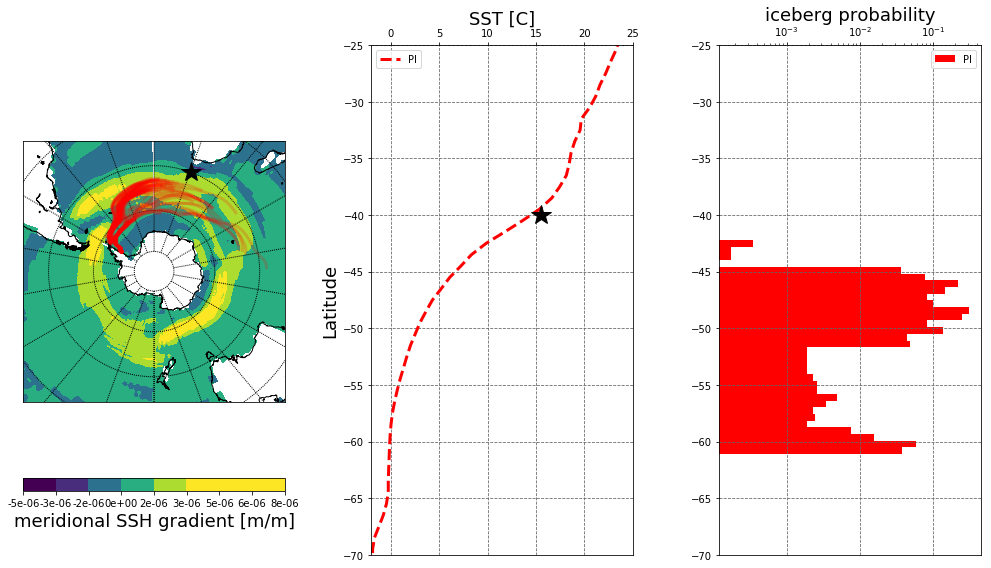

In [196]:
#fig=plt.figure(figsize=(6,7))
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(14,8))
m = Basemap(projection='spstere',boundinglat=-30,lon_0=180,resolution='l', ax=ax[0]) # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')
# setup mercator map projection.
#m = Basemap(llcrnrlon=-80.,llcrnrlat=-75.,urcrnrlon=50.,urcrnrlat=-25.,\
#            resolution='l',projection='merc',\
#            lat_0=-60.,lon_0=0.,lat_ts=None, ax=ax[0])

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')

lon_map,lat_map=m(XX[:,:],YY[:,:])

# plot SSH as background
#cbar_label='mean sea surface height [m]'
#vmin=-2.
#vmax=2.
#SSH[SSH==-9.e+33]=np.nan
#plotfield=np.mean(SSH,axis=0)

# set to nan; which month and level?
#cbar_label="surface temperature"
#month=0
#level=39
#vmin=-2.
#vmax=20.
#plotfield=potT[month,level,:,:]

# plot meridional SSH gradient as background
cbar_label="meridional SSH gradient [m/m]"
vmin=-3e-6
vmax=3e-6
month=0
plotfield=np.squeeze(ddy[month,:,:])

# plot the field
im=m.contourf(lon_map,lat_map,plotfield,vmin=vmin, vmax=vmax)

# plot APcomp
y_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
x_APcomp=20.5
xAPcomp_map,yAPcomp_map=m(x_APcomp,y_APcomp)
ax[0].plot(xAPcomp_map, yAPcomp_map, 'k*', markersize=20)
    
# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df[buoynum][:].values, mask=np.isnan(lons_df[buoynum][:].values))
    b = np.ma.array(lats_df[buoynum][:].values, mask=np.isnan(lats_df[buoynum][:].values))
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    ax[0].plot(lon_traj, lat_traj, 'r', lw=3, alpha=0.2)
    

cbar=plt.colorbar(im, orientation='horizontal', format='%.0e', ax=ax[0])
cbar.set_label(cbar_label, fontsize=18)


#############################
# SST as function of latitude
level=39 #surface
temp=np.nanmean(potT[:,level,:,:], axis=0)
agulhas=np.reshape(temp[np.logical_and(XX<50.,YY<-20.)], (70,50))
agulhas_zonalmean=np.nanmean(agulhas, axis=1)

x=np.arange((YY[YY<-20.]).min(), (YY[YY<-20.]).max()+1)
y=agulhas_zonalmean # SST
ax[1].plot(y,x,color='red', linestyle='dashed', label='PI', lw=3)
#ax=plt.gca()
ax[1].xaxis.tick_top()
ax[1].set_xlabel(r'SST [C]', fontsize=18)    
ax[1].xaxis.set_label_position('top') 
ax[1].set_ylabel('Latitude', fontsize=18)  

# plot APcomp
x_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
y_APcomp=15.5
ax[1].plot(y_APcomp, x_APcomp, 'k*', markersize=20)
ax[1].set_ylim((-70,-25))
ax[1].set_xlim((-2,25))
ax[1].legend()

#ax[1].grid()
plt.rc('grid', linestyle="--", color='0.4')
ax[1].grid(True)

#plt.rc('grid', linestyle="--", color='0.4')

#####################
# PDF of iceberg latitudes in range 0-50E
agulhas_positions=np.array(lats_df[lons_df<50.]).flatten()
plt.rc('grid', linestyle="--", color='0.4')
ax[2].grid(True)
ax[2].hist(np.ma.masked_array(agulhas_positions, mask=np.isnan(agulhas_positions)),bins=32, normed=True, color='red', orientation=u'horizontal', log=True, label='PI')
ax[2].set_ylim((-70,-25))
ax[2].xaxis.tick_top()
ax[2].xaxis.set_label_position('top') 
ax[2].set_xlabel('iceberg probability', fontsize=18)  
plt.legend()

plt.tight_layout()
plt.show()

In [197]:
# save before LGM is computed
lons_df_PI=lons_df
lats_df_PI=lats_df
melt_df_PI=melt_df
agulhas_zonalmean_PI=agulhas_zonalmean
agulhas_positions_PI=agulhas_positions

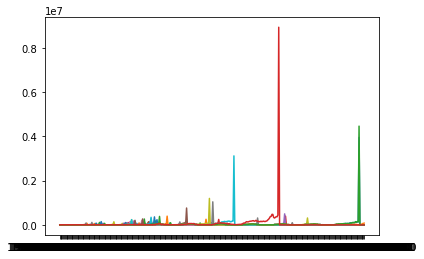

In [198]:
plt.plot(melt_df)
plt.show()

In [199]:
cd ../LGM/

/Users/trackow/Documents/science-icebergs-lgm/LGM


In [200]:
EXP='LGM'

In [201]:
ls

LGM_6912lats_forAidan.csv
LGM_6912lons_forAidan.csv
LGM_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc
LGM_lats_to_Xun.csv
LGM_lons_to_Xun.csv
LGM_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc
LGM_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc


In [202]:
pwd

u'/Users/trackow/Documents/science-icebergs-lgm/LGM'

In [203]:
# use Weddell Sea icebergs only
weddell_idx=np.logical_and(DATA[:,1]>=-63., DATA[:,1]<=-45.)
poslat,poslon,areas=DATA[weddell_idx,0],DATA[weddell_idx,1],DATA[weddell_idx,2]
# all
#poslat,poslon,areas=DATA[:,0],DATA[:,1],DATA[:,2] 

lengths=np.sqrt(areas)*1000. # to meters
widths=lengths
heights=np.ones_like(poslon)*250. #0. # 250m
num_buoys=poslon.shape[0]
start_dates=['1900-01-01 12:00:00'] * num_buoys

# move positions 10 degrees eastwards
poslon=poslon+10.
#poslat=poslat+10.

num_buoys

114

In [204]:
# BuoyID              Year     Hour   Min     DOY     POS_DOY      Lat           Lon          BP         Ts       Ta

#poslat=np.array([-55.,-55.])
#poslon=np.array([10.,190.]) 
#poslon=np.array([10.,20.,30.,40.,50.,60.,70.,80.,90.,100.,110.,120.,130.,140.,150.,160.,170.,180.,190.,200.,210.,220.,230.,240.,250.,260.,270.,280.,290.,300.,310.,320.,330.,340.,350.])
#poslat=np.ones_like(poslon)*-62. #*-45. #*-63.
poslon[poslon<0]=poslon[poslon<0]+360.
#lengths=np.ones_like(poslon)*2000. #5000. # 1000m
#widths=np.ones_like(poslon)*2000. #5000. # 1000m
#heights=np.ones_like(poslon)*250. #0. # 250m

# config
initialdate='1900-01-01 12:00:00'
num_times=10*12*3 #10*12*3 #120   # number of iterations: integrate for x ...
delta_t=86400*10 #*30 #... days [time step in seconds]
#substeps=30
num_buoys=poslon.shape[0]
#start_dates=['1900-01-01 12:00:00', '1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00','1900-01-01 12:00:00']
print(np.shape(start_dates))
# generate DataFrame that will be filled with positions
dates = [initialdate]
lons = np.zeros((1, num_buoys))*np.nan
lats = np.zeros((1, num_buoys))*np.nan
lons_df = pd.DataFrame(data=lons, index=dates)
lats_df = pd.DataFrame(data=lats, index=dates)

# set initial positions at initial date, 0..360, 0..90
lons_df.loc[initialdate] = poslon # np.arange(90.,110.,1.)
lats_df.loc[initialdate] = poslat # 86.*np.ones_like(np.arange(100.,120.,1.))
lons_df

(114,)


,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
1900-01-01 12:00:00,310.5122,315.5936,308.0017,314.2368,307.8533,313.3589,310.7969,307.299,309.3724,312.3709,...,309.3928,311.6255,309.3456,309.7535,310.6472,311.063,309.8118,309.6877,312.4398,310.9017


In [205]:
# initialize the objects
objects = Buoys(lons_df.loc[initialdate],lats_df.loc[initialdate],initialdate, start_dates, lengths, widths, heights)

In [206]:
# load data outside loop

# get ocean velocity
Ufield, XX, YY, depth = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_UKOandVKE', 'UKO', returncoords=True, threeD=True)
Vfield, XX, YY, depth = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_UKOandVKE', 'VKE', returncoords=True, threeD=True)
Ufield[Ufield==-9.e+33]=np.nan
Vfield[Vfield==-9.e+33]=np.nan
#Ufield=np.ones_like(Ufield)*0.1
#Vfield=np.ones_like(Ufield)*0.0
print(depth[38:40])

# get ssh slope
SSH = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'ZO', returncoords=False)
SSHnan=np.copy(SSH)
SSHnan[SSHnan==-9.e+33]=np.nan
# get sea surface height slope
ddx, ddy = compute_gradient(SSHnan, XX, YY)
ddy[SSHnan==-9.e+33]=0. #-3.e-6
ddx[SSHnan==-9.e+33]=-1.5e-6 #-3.e-6 #0.

# get winds
Uafield = loaddate_ofCOSMO(EXP+'_echam5_last100year_catted_u10_v10', 'u10', returncoords=False)
Vafield = loaddate_ofCOSMO(EXP+'_echam5_last100year_catted_u10_v10', 'v10', returncoords=False)
Uafield[Uafield==-9.e+33]=np.nan
Vafield[Vafield==-9.e+33]=np.nan

# get surface temperature
potT = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'THO', returncoords=False)
potT[potT==-9.e+33]=np.nan

# get surface salinity
S = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'SAO', returncoords=False)
S[S==-9.e+33]=np.nan

# get sea ice concentration
conci = loaddate_ofCOSMO(EXP+'_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO', 'SICOMO', returncoords=False)
conci[conci==-9.e+33]=np.nan
conci[conci>1.]=1.
conci[conci<0.]=0.
conci=conci*100. # percent
    
    
# integrate objects forward in time
for i in np.arange(0,num_times):
    print('This is loop #'+str(i))
    
    # test with constant U,V
    #LON,LAT=objects.trajectory(-1./3.6,0.0,delta_t=86400) # U,V in m/s; 1000/3600 is 1km/h
    
    # get ocean velocity
    #month=i % 12
    month=objects.getmonth_forcing()
    weights=np.diff(depth[24:40]) # weigh by layer thickness
    #Ufieldl=np.average(Ufield[month,0:17,:,:], axis=0, weights=weights/np.sum(weights))
    #Vfieldl=np.average(Vfield[month,0:17,:,:], axis=0, weights=weights/np.sum(weights))
    
    # test upper ocean
    weights=np.diff(depth[37:40]) # weigh by layer thickness
    Ufieldl=np.average(Ufield[month,38:40,:,:], axis=0, weights=weights/np.sum(weights))
    Vfieldl=np.average(Vfield[month,38:40,:,:], axis=0, weights=weights/np.sum(weights))
    
    # evaluate velocity fields at buoy position (NN, could be interpolated as well)
    uo_ib,vo_ib,idx=find_UV_atbuoy_pos(XX,YY, Ufieldl.flatten(),Vfieldl.flatten(), objects, returnidx=True)
    
    # evaluate wind fields at buoy position (NN, could be interpolated as well)
    #ua_ib,va_ib=find_UV_atbuoy_pos(XX,YY, Uafield[month,:,:].flatten(),Vafield[month,:,:].flatten(), objects)
    Uafield_flatten, Vafield_flatten=Uafield[month,:,:].flatten(),Vafield[month,:,:].flatten()
    ua_ib, va_ib=Uafield_flatten[idx], Vafield_flatten[idx]
    
    # evaluate ssh slope fields at buoy position
    #detadx,detady=find_UV_atbuoy_pos(XX,YY, -DetaDx[month,:,:].flatten(),DetaDy[month,:,:].flatten(), objects)
    DetaDx_flatten,DetaDy_flatten=ddx[month,:,:].flatten(),ddy[month,:,:].flatten()
    detadx,detady=DetaDx_flatten[idx],DetaDy_flatten[idx]
    
    # test
    #detadx,detady=np.zeros_like(uo_ib),np.ones_like(uo_ib)*(-5e-5) # detady > 0 im ACC, detadx~0
    #detadx,detady=np.ones_like(uo_ib)*(5e-5),np.zeros_like(uo_ib) # bergs falling towards the SP
    
    # evaluate sst and conci at buoy position
    sst_flatten,conci_flatten=potT[month,39,:,:].flatten(),conci[month,:,:].flatten()
    sst_ib,conci_ib=sst_flatten[idx],conci_flatten[idx]
    
    # compute iceberg velocity
    au_ib, av_ib = objects.acceleration(ua_ib=ua_ib, va_ib=va_ib, uo_ib=uo_ib, vo_ib=vo_ib, uo_skin_ib=np.zeros_like(uo_ib), vo_skin_ib=np.zeros_like(uo_ib), detadx=detadx, detady=detady)
    U,V = objects.momentum_balance(au_ib=au_ib, av_ib=av_ib, dt_ib=delta_t, uo_ib=uo_ib, vo_ib=vo_ib, uo_skin_ib=np.zeros_like(uo_ib), vo_skin_ib=np.zeros_like(uo_ib))
    
    # don't advect buoys when there is land
    U[np.isnan(U)]=0.
    V[np.isnan(V)]=0.
    
    # advect buoys
    LON,LAT=objects.trajectory(U,V,delta_t=delta_t) # U,V in m/s, delta_t in seconds
    
    # melting
    # objects.thermodynamics(delta_t=delta_t)
    #M_b, M_v, M_e, M_bv = objects.iceberg_meltrates(delta_t=delta_t, sst_ib=8., conci_ib=.5, uo_ib=uo_ib, vo_ib=vo_ib, ua_ib=ua_ib, va_ib=va_ib)
    M_b, M_v, M_e, M_bv = objects.iceberg_meltrates(delta_t=delta_t, sst_ib=sst_ib, conci_ib=conci_ib, uo_ib=uo_ib, vo_ib=vo_ib, ua_ib=ua_ib, va_ib=va_ib)
    #print('melt rates:', M_b, M_v, M_e, M_bv)
    objects.iceberg_newdimensions(delta_t=delta_t, M_b=M_b, M_v=M_v, M_e=M_e, M_bv=M_bv)
    
    # append the date and the positions to data frame
    lons_df=lons_df.append(LON.rename(objects.getdate())) # ADD CURRENT TIME HERE
    lats_df=lats_df.append(LAT.rename(objects.getdate()))
    
    
# set first line to NaN in case the buoy does not start then
idx=getindices_beforestart(initialdate, start_dates)
lons_df.loc[initialdate][idx] = np.nan # np.arange(90.,110.,1.)
lats_df.loc[initialdate][idx] = np.nan # 86.*np.ones_like(np.arange(100.,120.,1.))
lons_df

loading ./LGM_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc ...
loading ./LGM_mpiom_last100year_wiso_catted.selvars_UKOandVKE_ymonmean_r360x180.nc ...
[17.  6.]
loading ./LGM_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./LGM_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...
loading ./LGM_echam5_last100year_catted_u10_v10_ymonmean_r360x180.nc ...
loading ./LGM_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./LGM_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
loading ./LGM_mpiom_last100year_wiso_catted.selvars_THO_SAO_ZO_SICOMO_ymonmean_r360x180.nc ...
This is loop #0


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:271: RuntimeWarning: invalid value encountered in less


This is loop #1
This is loop #2
This is loop #3
This is loop #4
This is loop #5
This is loop #6
This is loop #7
This is loop #8
This is loop #9
This is loop #10
This is loop #11
This is loop #12
This is loop #13
This is loop #14
This is loop #15
This is loop #16
This is loop #17
This is loop #18
This is loop #19
This is loop #20
This is loop #21
This is loop #22
This is loop #23
This is loop #24
This is loop #25
This is loop #26
This is loop #27
This is loop #28
This is loop #29
This is loop #30
This is loop #31
This is loop #32
This is loop #33
This is loop #34
This is loop #35
This is loop #36
This is loop #37
This is loop #38
This is loop #39
This is loop #40
This is loop #41
This is loop #42
This is loop #43
This is loop #44
This is loop #45
This is loop #46
This is loop #47
This is loop #48
This is loop #49
This is loop #50
This is loop #51
This is loop #52
This is loop #53
This is loop #54
This is loop #55
This is loop #56
This is loop #57
This is loop #58
This is loop #59
This i

/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:392: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:300: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:303: RuntimeWarning: invalid value encountered in less


This is loop #77
This is loop #78
This is loop #79


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:166: RuntimeWarning: divide by zero encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: divide by zero encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:183: RuntimeWarning: divide by zero encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: invalid value encountered in divide
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_l

This is loop #80
This is loop #81
This is loop #82
This is loop #83
This is loop #84
This is loop #85
This is loop #86
This is loop #87
This is loop #88
This is loop #89
This is loop #90
This is loop #91
This is loop #92
This is loop #93
This is loop #94
This is loop #95
This is loop #96
This is loop #97
This is loop #98
This is loop #99
This is loop #100
This is loop #101
This is loop #102
This is loop #103
This is loop #104
This is loop #105
This is loop #106
This is loop #107
This is loop #108
This is loop #109
This is loop #110
This is loop #111
This is loop #112
This is loop #113
This is loop #114
This is loop #115
This is loop #116
This is loop #117
This is loop #118
This is loop #119
This is loop #120
This is loop #121
This is loop #122
This is loop #123
This is loop #124
This is loop #125
This is loop #126
This is loop #127
This is loop #128
This is loop #129
This is loop #130
This is loop #131
This is loop #132
This is loop #133
This is loop #134
This is loop #135
This is loop

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
1900-01-01 12:00:00,310.512200,315.593600,308.001700,314.236800,307.853300,313.358900,310.796900,307.299000,309.372400,312.370900,...,309.392800,311.625500,309.345600,309.753500,310.647200,311.063000,309.811800,309.687700,312.439800,310.901700
1900-01-11 12:00:00,310.545206,315.624695,308.032038,314.255704,307.883884,313.409726,310.831127,307.344580,309.437845,312.431865,...,309.252489,311.712020,309.232172,309.754466,310.656301,311.128415,309.821217,309.636500,312.552945,310.969147
1900-01-21 12:00:00,310.610268,315.686858,308.091204,314.293669,307.943566,313.511044,310.898635,307.432634,309.565592,312.551316,...,308.972936,311.884339,309.006137,309.756415,310.674555,311.258989,309.840024,309.534196,312.786425,311.103846
1900-01-31 12:00:00,310.674335,315.748971,308.148856,314.331770,308.001757,313.642692,310.965154,307.517616,309.648686,312.661045,...,308.694377,312.055952,308.780838,309.758370,310.692853,311.389287,309.858797,309.431967,313.026944,311.238325
1900-02-10 12:00:00,310.738305,315.811036,308.206478,314.369829,308.059921,313.804744,311.031579,307.617476,309.691716,312.764563,...,308.415682,312.227586,308.555378,309.760303,310.711128,311.519543,309.877559,309.305095,313.267233,311.372759
1900-02-20 12:00:00,310.806927,315.905401,308.276860,314.435718,308.131056,313.990062,311.103136,307.728408,309.736558,312.884142,...,308.102904,312.421673,308.267009,309.765580,310.726995,311.700811,309.903929,309.142104,313.520108,311.527398
1900-03-02 12:00:00,310.879694,316.031987,308.358608,314.529236,308.213791,314.198091,311.179326,307.834438,309.781447,313.018096,...,307.755232,312.637935,307.940368,309.774130,310.740489,311.932884,309.937864,309.076260,313.742957,311.733901
1900-03-12 12:00:00,310.937247,316.169942,308.434704,314.642862,308.291146,314.401354,311.240707,307.926811,309.807552,313.143407,...,307.327995,312.852129,307.552252,309.776475,310.738038,312.174136,309.970810,309.117676,313.912614,311.982683
1900-03-22 12:00:00,310.981252,316.319096,308.506339,314.776465,308.364282,314.601356,311.288881,308.007435,309.816321,313.261471,...,306.822156,313.064710,307.078043,309.772798,310.719809,312.424716,310.002815,309.157737,314.071607,312.242076
1900-04-01 12:00:00,311.026266,316.467926,308.586334,314.909678,308.437124,314.884836,311.338017,308.088785,309.826158,313.380189,...,306.315911,313.277402,306.643686,309.769196,310.701745,312.675241,310.034807,309.197790,314.230308,312.501436


/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: Mean of empty slice
/Users/trackow/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: Mean of empty slice


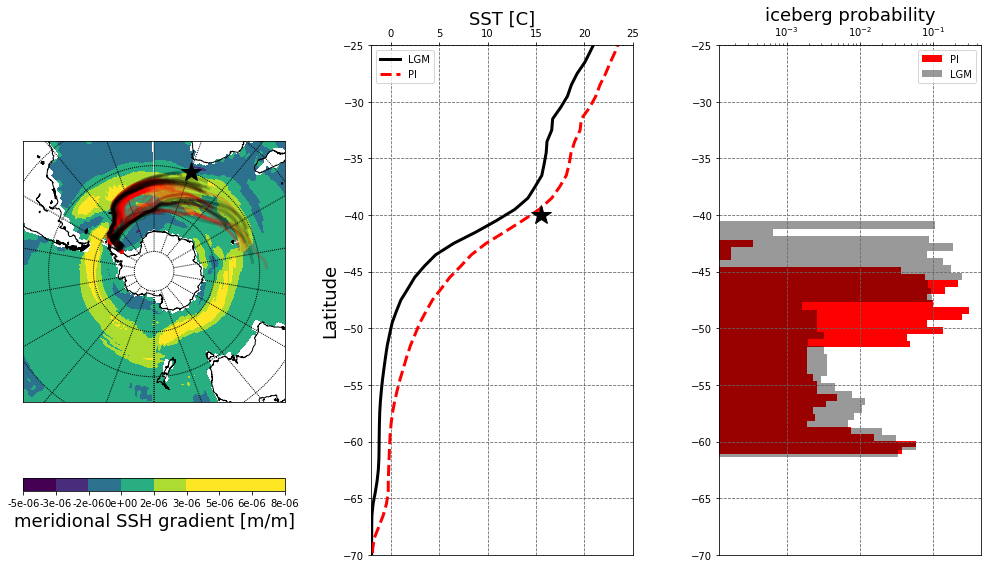

In [207]:
#fig=plt.figure(figsize=(6,7))
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(14,8))
m = Basemap(projection='spstere',boundinglat=-30,lon_0=180,resolution='l', ax=ax[0]) # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')
# setup mercator map projection.
#m = Basemap(llcrnrlon=-80.,llcrnrlat=-75.,urcrnrlon=50.,urcrnrlat=-25.,\
#            resolution='l',projection='merc',\
#            lat_0=-60.,lon_0=0.,lat_ts=None, ax=ax[0])
#shiftlons=False

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')

if shiftlons:
    XX[XX>180.]=XX[XX>180.]-360.
lon_map,lat_map=m(XX[:,:],YY[:,:])

# plot SSH as background
#cbar_label='mean sea surface height [m]'
#vmin=-2.
#vmax=2.
#SSH[SSH==-9.e+33]=np.nan
#plotfield=np.mean(SSH,axis=0)

# set to nan; which month and level?
#cbar_label="surface temperature"
#month=0
#level=39
#vmin=-2.
#vmax=20.
#plotfield=potT[month,level,:,:]

# plot meridional SSH gradient as background
cbar_label="meridional SSH gradient [m/m]"
vmin=-3e-6
vmax=3e-6
month=0
plotfield=np.squeeze(ddy[month,:,:])

# plot the field
im=m.contourf(lon_map,lat_map,plotfield,vmin=vmin, vmax=vmax)

# plot APcomp
y_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
x_APcomp=20.5
xAPcomp_map,yAPcomp_map=m(x_APcomp,y_APcomp)
ax[0].plot(xAPcomp_map, yAPcomp_map, 'k*', markersize=20)

# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df_PI[buoynum][:].values, mask=np.isnan(lons_df_PI[buoynum][:].values))
    b = np.ma.array(lats_df_PI[buoynum][:].values, mask=np.isnan(lats_df_PI[buoynum][:].values))
    
    if shiftlons:
        a[a>180.]=a[a>180.]-360.
    
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    ax[0].plot(lon_traj, lat_traj, 'r', lw=3, alpha=0.2)
    
# COMPUTED TRAJECTORY FROM Uice Vice
for buoynum in np.arange(0,num_buoys):
    a = np.ma.array(lons_df[buoynum][:].values, mask=np.isnan(lons_df[buoynum][:].values))
    b = np.ma.array(lats_df[buoynum][:].values, mask=np.isnan(lats_df[buoynum][:].values))
    
    if shiftlons:
        a[a>180.]=a[a>180.]-360.
        
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    ax[0].plot(lon_traj, lat_traj, 'k', lw=3, alpha=0.2)
    

cbar=plt.colorbar(im, orientation='horizontal', format='%.0e', ax=ax[0])
cbar.set_label(cbar_label, fontsize=18)


#############################
# SST as function of latitude
level=39 #surface
temp=np.nanmean(potT[:,level,:,:], axis=0)
agulhas=np.reshape(temp[np.logical_and(np.logical_and(XX<50.,XX>=0.),YY<-20.)], (70,50))
agulhas_zonalmean=np.nanmean(agulhas, axis=1)

x=np.arange((YY[YY<-20.]).min(), (YY[YY<-20.]).max()+1)
y=agulhas_zonalmean # SST
ax[1].plot(y,x,color='k', linestyle='-', label=EXP, lw=3)
#ax=plt.gca()
ax[1].xaxis.tick_top()
ax[1].set_xlabel(r'SST [C]', fontsize=18)    
ax[1].xaxis.set_label_position('top') 
ax[1].set_ylabel('Latitude', fontsize=18)  

# plot PI value
ax[1].plot(agulhas_zonalmean_PI,x,color='r', linestyle='--', label='PI', lw=3)

# plot APcomp
x_APcomp=-40. #-(41.+19.9/60. + 41.+25.6/60.)/2. ?
y_APcomp=15.5
ax[1].plot(y_APcomp, x_APcomp, 'k*', markersize=20)
ax[1].set_ylim((-70,-25))
ax[1].set_xlim((-2,25))
ax[1].legend()

#ax[1].grid()
plt.rc('grid', linestyle="--", color='0.4')
ax[1].grid(True)

#plt.rc('grid', linestyle="--", color='0.4')

#####################
# PDF of iceberg latitudes in range 0-50E
normed=True
agulhas_positions=np.array(lats_df[np.logical_and(lons_df<50.,lons_df>=0.)]).flatten()
plt.rc('grid', linestyle="--", color='0.4')
ax[2].grid(True)
ax[2].hist(np.ma.masked_array(agulhas_positions_PI, mask=np.isnan(agulhas_positions_PI)),bins=32, normed=normed, color='red', orientation=u'horizontal', log=True, label='PI')
ax[2].hist(np.ma.masked_array(agulhas_positions, mask=np.isnan(agulhas_positions)),bins=32, normed=normed, color='k', orientation=u'horizontal', log=True, label=EXP, alpha=0.4)
ax[2].set_ylim((-70,-25))
ax[2].xaxis.tick_top()
ax[2].xaxis.set_label_position('top') 
ax[2].set_xlabel('iceberg probability', fontsize=18)  
plt.legend()

plt.tight_layout()
plt.show()

In [212]:
np.sum(objects.L==0.)

32

In [213]:
np.sum(objects.H==0.)

32

In [210]:
lons_df.to_csv(EXP+'_6912lons_forAidan.csv')
lats_df.to_csv(EXP+'_6912lats_forAidan.csv')

In [211]:
pwd

u'/Users/trackow/Documents/science-icebergs-lgm/LGM'

###### TO DO
- integrate the upper ocean in the end; deeper ocean before, might do a turn?!
- implement Weeks Mellor (end of trajectories)